In [97]:
import pandas as pd
import os
from tqdm import tqdm
from sportypy.surfaces import MiLBField
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from plotting import plot_animation

In [3]:
help(plot_animation)

Help on function plot_animation in module plotting:

plot_animation(player_position_df: pandas.core.frame.DataFrame, ball_position_df: pandas.core.frame.DataFrame, play_id: int = 1, save_gif: bool = False) -> IPython.core.display.HTML
    A function that plots field animations for a particular instance of a game.
    Example usage:
    
    ```
    player_pos = pd.read_parquet('./Combined/player_pos/1884_110_Vis2AR_Home2A.parquet')
    ball_pos = pd.read_parquet('./Combined/ball_pos/1884_110_Vis2AR_Home2A.parquet')
    
    plot_animation(player_pos, ball_pos, play_id = 30, save_gif = True)
    ```
    
    Params:
        player_position_df: A Data Frame for the player position coordinates on a field.
        ball_position_df: A Data Frame for the ball position coordiantes on a field.
        play_id: A integer field that denotes the play id you want to visualize. Defaults to 1.
        save_gif: A boolean that when set to true saves the animation to a gif. 
                  Defaults

In [4]:
base = '/Users/eddie/SMT-Data-Challenge/Combined/'

In [38]:
game_events = pd.read_parquet(base + 'game_events.parquet')
game_info = pd.read_parquet(base + 'game_info.parquet')
team_info = pd.read_parquet(base + 'team_info.parquet')

In [39]:
game_events.sort_values(by=['game_str', 'timestamp', 'event_code'], inplace = True)

In [40]:
df = []

for subdir, dirs, files in os.walk(base + 'ball_pos/'):
    for file in files:
        sub_df = pd.read_parquet(base + 'ball_pos/' + file)
        df.append(sub_df)

ball_pos = pd.concat(df, ignore_index=True)

In [41]:
df = []  

for subdir, dirs, files in os.walk(base + 'player_pos/'):
    for file in tqdm(files, desc='Processing File'):
        sub_df = pd.read_parquet(base + 'player_pos/' + file, engine='fastparquet')
        df.append(sub_df)

player_pos = pd.concat(df, ignore_index=True)

Processing File: 100%|████████████████████████| 338/338 [00:10<00:00, 33.62it/s]
Processing File: 0it [00:00, ?it/s]


# Data Notes:

* Game ##.5 indicates a double header and that is the second game.
* All home teams are within the same farm system.
* Home 4A is highest and 1A is the lowest.
* 1883 season is only half a season and 1884 is a full season.
* Play ids **reset** every game

*player position codes*:
```
{
    1: pitcher
    2: catcher
    3: 1st Baseman
    4: 2nd Baseman
    5: Third basebam
    6: Shortstop
    7: Left Field
    8: Center Field
    9: Right Field
    10: Batter
    11: Runner on first
    12: Runner on second
    13: Runner on third
    255: Ball event with no player (past ball)
}
```
*event codes*:
```
{
    1: Pitch thrown
    2: Ball acquired
    3: Throw for ball in play
    4: Ball hit into play
    5: End of play
    6: Pickoff Throw
    7: Ball acquired: Unkown field position
    8: Throw for ball in play: Unknown field position
    9: Ball deflection
    10: Ball deflection off wall
    11: Home run
    16: Ball bounce
}
```

Question at hand: This year’s dataset will consist of multiple teams within a single farm system. We want you to consider a situation that compares
players, teams, and/or game play at two or more levels.

In [42]:
# Decode the Game Events

PLAYER_POSITION = {
    1: 'P',
    2: 'C',
    3: '1B',
    4: '2B',
    5: '3B',
    6: 'SS',
    7: 'LF',
    8: 'CF',
    9: 'RF',
    10: 'BA', # The batter
    11: 'R1B', # Runner on 1B
    12: 'R2B', # Runner on 2B
    13: 'R3B', # Runner on 3B
    255: 'NA' # Ball event with no player
}

EVENT_CODE = {
    1: 'Pitch',
    2: 'Fielded', # fielded ball
    3: 'Throw', # ball thrown
    4: 'In Play',
    5: 'End of Play',
    6: 'Pickoff',
    7: 'Fielded (Unknown)',
    8: 'Throw (Unknown)',
    9: 'Ball Deflection',
    10: 'Off Wall',
    11: 'HR',
    16: 'Ball Bounce' # Can bounce multiple times
}


game_events['player_position'] = game_events['player_position'].map(PLAYER_POSITION)
game_events['event_code'] = game_events['event_code'].map(EVENT_CODE)


In [43]:
outfield_positions = ['CF', 'RF', 'LF']

game_events['is_flyout'] = np.where(
    (game_events['player_position'].isin(outfield_positions)) & 
    (game_events['event_code'] == 'Fielded') &
    (game_events['event_code'].shift(-1) == 'End of Play'), 1, 0
)

In [44]:
game_events[game_events['is_flyout'] == 1]

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,is_flyout
55093,1883_001_Vis1AB_Home1A,2,1.0,2,73273,CF,Fielded,1
55100,1883_001_Vis1AB_Home1A,4,2.0,4,119873,LF,Fielded,1
55281,1883_001_Vis1AB_Home1A,49,12.0,49,1624623,CF,Fielded,1
55291,1883_001_Vis1AB_Home1A,52,13.0,52,1704123,LF,Fielded,1
55350,1883_001_Vis1AB_Home1A,66,16.0,66,2067123,RF,Fielded,1
...,...,...,...,...,...,...,...,...
211237,1884_143_Vis4BE_Home4A,35,8.0,34,1035250,RF,Fielded,1
211399,1884_143_Vis4BE_Home4A,82,21.0,81,2663500,LF,Fielded,1
212127,1884_143_Vis4BE_Home4A,274,69.0,273,9621300,CF,Fielded,1
212154,1884_143_Vis4BE_Home4A,281,71.0,280,9770950,RF,Fielded,1


In [261]:
# This filters plays where an outfielder fields the ball, a total of 3,163 observations. 
# No errors were included... for now
# Had to remove 3 instances that involved more than 1 outfielder likely due to a dropped or missed ball.
# 1883_021_Vis1AG_Home1A play 42 has a fielding error so I will try to capture that.


player_ids = game_info[['game_str', 'play_per_game', 'inning', 'top_bottom', 'left_field', 'center_field', 'right_field']]
#filter_v = game_events.loc[(game_events['player_position'].isin(['CF', 'RF', 'LF'])) & (game_events['event_code'] == 'Fielded'), 'game_str':'player_position']
filter_v = game_events[game_events['is_flyout'] == 1].iloc[:, :-2]
filter_v = pd.merge(filter_v, player_ids, on = ['game_str', 'play_per_game'], how = 'left')

filter_v[['left_field', 'center_field', 'right_field']] = filter_v.groupby(['game_str', 'top_bottom'])[['left_field', 'center_field', 'right_field']].ffill()


filter_v['player_id'] = np.where(
    filter_v['player_position'] == 'LF', filter_v['left_field'],
    np.where(
        filter_v['player_position'] == 'CF', filter_v['center_field'],
        filter_v['right_field']
    )
)

filter_v.drop(columns=['top_bottom', 'left_field', 'center_field', 'right_field'], inplace=True)

outfielders = player_pos[player_pos['player_position'].isin([7, 8, 9])]
ball_pos_out = pd.merge(filter_v, ball_pos, on=['game_str', 'play_id'], how='left')

player_pos_out = pd.merge(filter_v, outfielders, on = ['game_str', 'play_id'], how = 'left')


In [273]:
ball_pos_out = ball_pos_out.groupby(['game_str', 'play_id']).agg(
    ball_pos_start_x=('ball_position_x', 'first'),
    ball_pos_start_y=('ball_position_y', 'first'),
    ball_pos_start_z=('ball_position_z', 'first'),
    ball_pos_end_x=('ball_position_x', 'last'),
    ball_pos_end_y=('ball_position_y', 'last'),
    ball_pos_end_z=('ball_position_z', 'last'),
    timestamp_start=('timestamp_y', 'first'),
    timestamp_end=('timestamp_y', 'last')
).reset_index()

player_pos_out = player_pos_out.groupby(['game_str', 'play_id', 'player_position_y']).agg(
    field_start_x=('field_x', 'first'),
    field_start_y=('field_y', 'first'),
    field_end_x=('field_x', 'last'),
    field_end_y=('field_y', 'last'),
    player_position_x=('player_position_x', 'first'),
    timestamp_start=('timestamp_y', 'first'),
    timestamp_end=('timestamp_y', 'last'),
    inning = ('inning', 'first'),
    player_id = ('player_id', 'first')
).reset_index()

In [274]:
ball_pos_out = ball_pos_out[ball_pos_out['ball_pos_end_y'] >= 100] # Eliminate bad data that could be a pitch thrown



In [283]:
final = pd.merge(player_pos_out, ball_pos_out, on = ['game_str', 'play_id'], how = 'left', suffixes = ('', '_ball')).dropna(subset='ball_pos_start_x')



In [284]:
final['player_position_y'] = final['player_position_y'].map({7 : 'LF', 8 : 'CF', 9 : 'RF'})


In [285]:
final = final[final['player_position_y'] == final['player_position_x']]

In [155]:
def plot_heatmap(df):
    field = MiLBField()

    plt.figure(figsize=(12, 10))

    field.draw()

    positions = ['LF', 'CF', 'RF']

    for position in positions:
        position_data = df[df['player_position_y'] == position]
        sns.kdeplot(
            x=position_data['ball_pos_end_x'],
            y=position_data['ball_pos_end_y'],
            fill=True,
            cmap='magma',
            alpha=0.6,
            levels = 8,
            ax=plt.gca()
        )

        plt.text(position_data.field_start_x.mean(), position_data.field_start_y.mean(), 
                 position, fontsize=12, ha='center', color='black', fontweight = 'bold')

    plt.title('Heatmap of Caught Flyballs by Outfielders', c = 'w')

    plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

<Figure size 1200x1000 with 0 Axes>

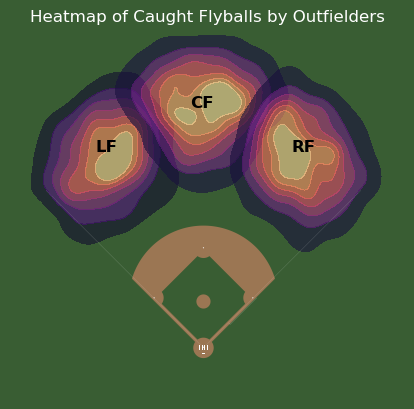

In [156]:
plot_heatmap(final)

In [154]:
# 94,499 events

(3163 / 94499) * 100
# About 3% of our plays are flyouts.

# CF	1237
# LF	1000
# RF	926 Play totals <–

3.3471253664059937

# Steps to Take

Identify how to make a range map. Essentially, it will be for **caught** fly balls so I will need to find where a player is in their starting position then where they end up on the field. You draw a line with opacity to it and it should output something like this:
[Outfield](https://grantland.com/the-triangle/2014-mlb-playoffs-exploiting-kansas-city-royals-ultimate-outfield-jarrod-dyson-alex-gordon-lorenzo-cain/)
This is going to be used for route efficiency. 


Here's what the model will be initially:
* Input features like hang time, angle to the ball, etc.
* Outputs the expected time for a player to reach the ball. 
* Compare it throughout the different leagues to see what players are getting to the ball.
* Once I have it, I could make a hexbin plot of where players are strong suited to where they may get to the ball from the outfield. 
* *Maybe* normalize it?


Note: **Do not join by timestamp. Do it by play id and game str**



TODO:
1. 

In [290]:
# Time it takes will be timestamp_start - timestamp_end_ball
# Distance is field_start_y - field_end_y
final['timestamp_start_seconds'] = final['timestamp_start'] / 1000
final['timestamp_start_ball_seconds'] = final['timestamp_start_ball'] / 1000
final['timestamp_end_ball_seconds'] = final['timestamp_end_ball'] / 1000

final['distance_to_ball'] = abs((final['field_start_y'] - final['field_end_y']))
final['sprint_speed'] = (final['distance_to_ball']) / (final['timestamp_end_ball_seconds'] - final['timestamp_start_seconds'])


# final['hang_time'] = final['timestamp_end_ball_seconds'] - final['timestamp_start_ball_seconds']

# We are trying to predict this
# Shoot can't use hang time. Will have to use exit velo and launch angle
final['actual_time'] = final['timestamp_end_ball_seconds'] - final['timestamp_start_seconds']



In [300]:
final['max_speed'] = final.groupby('player_id')['sprint_speed'].transform('max')
final['max_speed'].fillna(11.888987, inplace = True) # gonna fill in with the median speed


In [304]:
final.isna().sum()

game_str                          0
play_id                           0
player_position_y                 0
field_start_x                     0
field_start_y                     0
field_end_x                       0
field_end_y                       0
player_position_x                 0
timestamp_start                   0
timestamp_end                     0
inning                           14
player_id                       432
ball_pos_start_x                  0
ball_pos_start_y                  0
ball_pos_start_z                  0
ball_pos_end_x                    0
ball_pos_end_y                    0
ball_pos_end_z                    0
timestamp_start_ball              0
timestamp_end_ball                0
timestamp_start_seconds           0
timestamp_start_ball_seconds      0
timestamp_end_ball_seconds        0
distance_to_ball                  0
sprint_speed                      0
actual_time                       0
max_speed                         0
dtype: int64

In [313]:
# Ok let's attempt a regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

features = ['distance_to_ball', 'max_speed']
target = ['actual_time']

X = final[features]
y = final[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

reg = LinearRegression()

reg.fit(X_train, y_train)

pred = reg.predict(X_test)

In [317]:
print("Coefficients [[distance to ball, max speed]]: \n", reg.coef_)

print("Mean squared error: %.2f" % mean_squared_error(y_test, pred))

print("R^2: %.2f" % r2_score(y_test, pred))


Coefficients [[distance to ball, max speed]]: 
 [[ 0.01234728 -0.04559868]]
Mean squared error: 3.07
R^2: 0.08


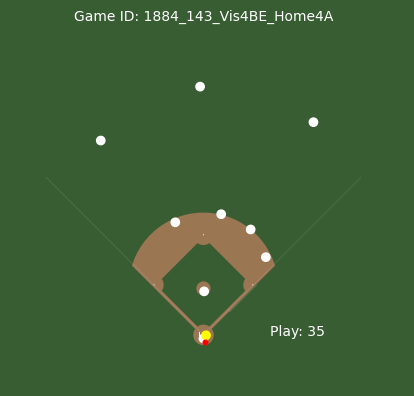

In [24]:
player_pos = pd.read_parquet('./Combined/player_pos/1884_143_Vis4BE_Home4A.parquet')
ball_pos = pd.read_parquet('./Combined/ball_pos/1884_143_Vis4BE_Home4A.parquet')

plot_animation(player_pos, ball_pos, play_id = 35)

In [158]:
unique_teams = team_info.groupby('player_id')['home_team'].nunique().sort_values(ascending = False).reset_index()


positions = game_info.iloc[:, 7:16]

players = {}
for position in positions.columns:
    players[position] = set(positions[position].dropna())
    
    
for position, ids in players.items():
    for id_ in ids:
        team_indices = unique_teams.index[unique_teams['player_id'] == id_].tolist()
        unique_teams.loc[team_indices, 'position'] = position
        
unique_teams[unique_teams['home_team'] > 1]['position'].value_counts()

position
pitcher         42
right_field     10
shortstop        7
catcher          6
center_field     5
left_field       4
third_base       4
first_base       3
second_base      2
Name: count, dtype: int64

In [165]:
unique_teams['position'].value_counts()

position
pitcher         110
right_field      27
catcher          14
shortstop        13
first_base       10
center_field     10
left_field        8
third_base        8
second_base       2
nan               1
Name: count, dtype: int64

In [ ]:
player_pos_out.groupby(['game_str', 'play_id']).agg({'player_position_x' : 'nunique'}).reset_index().sort_values(by='player_position_x')

